In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pylab as plt
from dagger.graph import DAG, _calc_prior_discrete, _nodes_to_handle, _group_probs

In [3]:
df = pd.DataFrame({"a": [1,0,1,0,1], "b": [1,1,1,0,0], "c":[0,0,1,0,1] })

In [4]:
dag = DAG(df).add_edge("a", "b").add_edge("b", "c").add_edge("a", "c")

In [5]:
df = pd.DataFrame({"a": [1, 1, 1, 1, 0, 0, 0], 
                   "b": [0, 1, 0, 1, 0, 0, 1], 
                   "c": [0, 0, 1, 0, 0, 1, 0]})
dag = DAG(df).add_edge("a", "b").add_edge("c", "b").add_edge("a", "c")

In [6]:
def get_root_nodes(dag, nodes):
    graph = dag.graph.copy() 
    for node in nodes: 
        graph.remove_node(node)
    return tuple(x for x in graph.nodes() if graph.in_degree(x) == 0)

def get_leaf_nodes(dag, nodes):
    graph = dag.graph.copy()
    for node in nodes: 
        graph.remove_node(node)
    return tuple(x for x in graph.nodes() if graph.out_degree(x) == 0)

def normalise(x):
    return x/x.sum()

def merge_probs(frame1, frame2, col):
    return (frame1
             .set_index(col)
             .join(frame2.set_index(col), lsuffix="1", rsuffix="2")
             .assign(p = lambda x: normalise(x.p1 * x.p2))
             .drop("p1", axis=1)
             .drop("p2", axis=1)
             .reset_index())

In [8]:
nodes_done = set()
distributions = {}
nodes_to_do = set(dag._priors.keys())
prior_copy = dag._priors.copy()
while nodes_done != set(dag.graph.nodes):
    current_root_nodes = get_root_nodes(dag, nodes_done)
    for node in current_root_nodes:
        parents = list(dag.graph.predecessors(node))
        prob_df = (df
                   .assign(n=1)
                   .groupby(parents + [node])
                   .count()['n']
                   .reset_index()
                   .assign(p=lambda d: d.n/d.n.sum()))
        if len(parents) != 0:
            prob_df = prob_df.pipe(_group_probs, parents=parents)
        else:
            prob_df = prob_df.drop(columns=["n"])
        distributions[node] = prob_df
        nodes_done.add(node)

In [16]:
list(dag.graph.predecessors("a"))

TypeError: object of type 'dict_keyiterator' has no len()

In [26]:
nodes_done = set()

current_leaf_nodes = get_leaf_nodes(dag, nodes_done)
model_df = distributions[current_leaf_nodes[0]]
while nodes_done != set(dag.graph.nodes):
    current_leaf_nodes = get_leaf_nodes(dag, nodes_done)
    for node in current_leaf_nodes:
        parents = list(dag.graph.predecessors(node))
        for p in parents:
            print(f"node={node}, parents={parents}, parent={p}")
            print(model_df)
            print(distributions[p])
            model_df = merge_probs(model_df, distributions[p], p)
            print(model_df)
            if len(list(dag.graph.predecessors(p))) == 0:
                nodes_done.add(p)
        nodes_done.add(node)

model_df

node=b, parents=['a', 'c'], parent=a
   a  c  b         p
0  0  0  0  0.500000
1  0  0  1  0.500000
2  0  1  0  1.000000
3  1  0  0  0.333333
4  1  0  1  0.666667
5  1  1  0  1.000000
   a         p
0  0  0.428571
1  1  0.571429
   a  c  b         p
0  0  0  0  0.107143
1  0  0  1  0.107143
2  0  1  0  0.214286
3  1  0  0  0.095238
4  1  0  1  0.190476
5  1  1  0  0.285714
node=b, parents=['a', 'c'], parent=c
   a  c  b         p
0  0  0  0  0.107143
1  0  0  1  0.107143
2  0  1  0  0.214286
3  1  0  0  0.095238
4  1  0  1  0.190476
5  1  1  0  0.285714
   a  c         p
0  0  0  0.666667
1  0  1  0.333333
2  1  0  0.750000
3  1  1  0.250000
    c  a1  b  a2         p
0   0   0  0   0  0.071429
1   0   0  0   1  0.080357
2   0   0  1   0  0.071429
3   0   0  1   1  0.080357
4   0   1  0   0  0.063492
5   0   1  0   1  0.071429
6   0   1  1   0  0.126984
7   0   1  1   1  0.142857
8   1   0  0   0  0.071429
9   1   0  0   1  0.053571
10  1   1  0   0  0.095238
11  1   1  0   1  0.071429

KeyError: 'a'

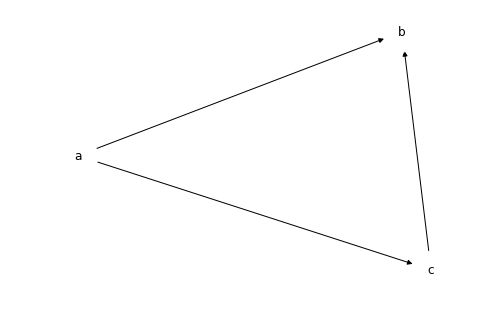

In [10]:
dag.nx_plot(node_size=1500, with_labels=True, node_color="white")